# Web page Phishing Detection Dataset
### Visualization of the results

#### Imports

In [1]:
import sys
sys.path.append('../../src/helpers')
sys.path.append('../../src')
sys.path.append('../../demo')
sys.path.append('../../data/external')

from score_model import *
from pca import *
from utils import *
from generate_features import *

#### Settings

In [2]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

### Loading the data

These steps are explained in detail in the demo file "loading_data.py"

In [3]:
x, y = load_dataset('..\..\data\external\dataset_phishing.csv')

print("Number of samples:", x.shape[0])
print("Number of features:", x.shape[1])

Number of samples: 11430
Number of features: 88


In [4]:
known_domain_age = x.loc[x['domain_age'] != -1, 'domain_age']
mean_domain_age = known_domain_age.sum()/len(known_domain_age)

x.loc[x["domain_age"] == -1, 'domain_age'] = mean_domain_age

known_domain_registration_length = x.loc[x['domain_registration_length'] != -1, 'domain_registration_length']
mean_domain_registration_length = known_domain_registration_length.sum()/len(known_domain_registration_length)

x.loc[x["domain_registration_length"] == -1, 'domain_registration_length'] = mean_domain_registration_length

In [5]:
status_labels = y.copy() # "string" labels
y = y.replace({"phishing" : 1, "legitimate" : 0})
x = x.drop(columns = "url")

# Convert the data to float type
x = object_type_to_float(x)

In [6]:
categorical_features = ["ip", "http_in_path", "https_token", "punycode", "port", "tld_in_path", "tld_in_subdomain",\
"abnormal_subdomain", "prefix_suffix", "random_domain", "shortening_service", "path_extension", "domain_in_brand",\
"brand_in_subdomain", "brand_in_path", "suspecious_tld", "login_form", "external_favicon", "submit_email", "sfh",\
"iframe", "popup_window", "onmouseover", "right_clic", "empty_title", "domain_in_title", "domain_with_copyright",\
"whois_registered_domain", "dns_record", "google_index"]

x_standard = standardize(x, categorical_features = categorical_features)

In [7]:
best_atributes15 = select_features(x_standard, y, 15)
best_atributes30 = select_features(x_standard, y, 30)

# Dataset with the selected features and standardized
reduced_dataset_standard15 = x_standard[x_standard.columns[best_atributes15]]
reduced_dataset_standard15 = reduced_dataset_standard15.assign(status = y.values)

reduced_dataset_standard30 = x_standard[x_standard.columns[best_atributes30]]
reduced_dataset_standard30 = reduced_dataset_standard30.assign(status = y.values)

# Dataset without feature selection (standardized and non-standardized)
Full_dataset_standard = x_standard.assign(status = y.values) #Full dataset (without feature selection)
Full_dataset = x.assign(status = y.values) #Full dataset (without feature selection)

# 90% explained variance
pca_dataset90 = perform_pca(Full_dataset_standard, auto=True, obj_variance=0.90)

# 95% explained variance
pca_dataset95 = perform_pca(Full_dataset_standard, auto=True, obj_variance=0.95)

### Correlation analysis

Correlation of 15 best atributes by Mutual Information Classifier 

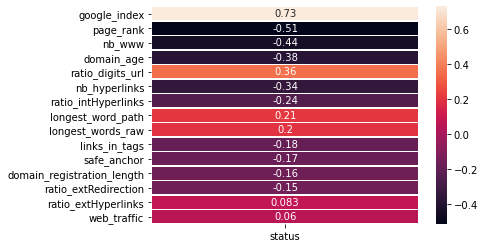

In [8]:
correlations = reduced_dataset_standard15.corr()
correlations = correlations[abs(correlations["status"]).sort_values(ascending=False).index].transpose()

plt.figure()
ax = sns.heatmap(pd.DataFrame(correlations["status"][1:]), annot=True, linewidths=.5)

In [9]:
print(x_standard.columns[best_atributes15].values)

['google_index' 'web_traffic' 'domain_age' 'ratio_intHyperlinks'
 'ratio_extHyperlinks' 'nb_hyperlinks' 'page_rank' 'safe_anchor'
 'domain_registration_length' 'ratio_extRedirection' 'links_in_tags'
 'nb_www' 'longest_word_path' 'ratio_digits_url' 'longest_words_raw']


Correlation of 15 best atributes by correlation 

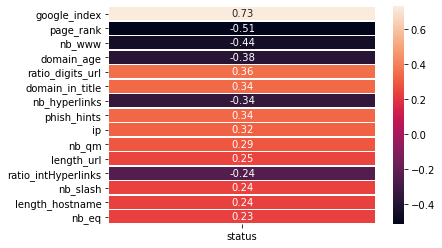

In [10]:
correlations = Full_dataset_standard.corr()
best_atributes_by_corr = abs(correlations["status"]).sort_values(ascending=False).index[1:16]
correlations = correlations[best_atributes_by_corr].transpose()


plt.figure()
ax = sns.heatmap(pd.DataFrame(correlations["status"]), annot=True, linewidths=.5)

In [11]:
print(best_atributes_by_corr.values)

['google_index' 'page_rank' 'nb_www' 'domain_age' 'ratio_digits_url'
 'domain_in_title' 'nb_hyperlinks' 'phish_hints' 'ip' 'nb_qm' 'length_url'
 'ratio_intHyperlinks' 'nb_slash' 'length_hostname' 'nb_eq']


### Atribute visualization

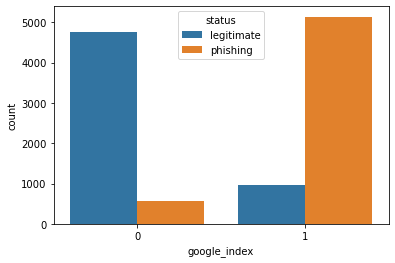

In [12]:
sns.countplot(x="google_index", data=Full_dataset_standard, hue=status_labels);

<AxesSubplot:xlabel='status', ylabel='page_rank'>

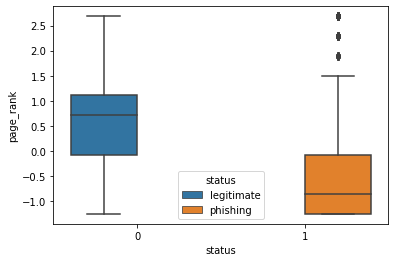

In [13]:
sns.boxplot(x="status", y="page_rank", data=Full_dataset_standard, hue=status_labels)

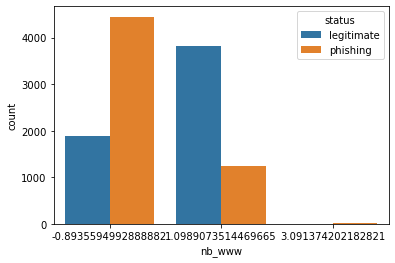

In [14]:
sns.countplot(x="nb_www", data=Full_dataset_standard, hue=status_labels);

<AxesSubplot:xlabel='status', ylabel='domain_age'>

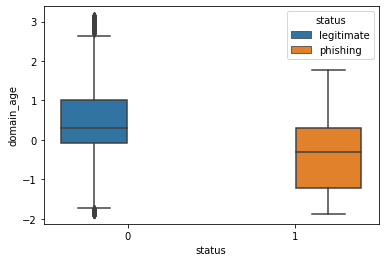

In [15]:
sns.boxplot(x="status", y="domain_age", data=Full_dataset_standard, hue=status_labels)

Proporcio de numeros/logitud

<AxesSubplot:xlabel='status', ylabel='ratio_digits_url'>

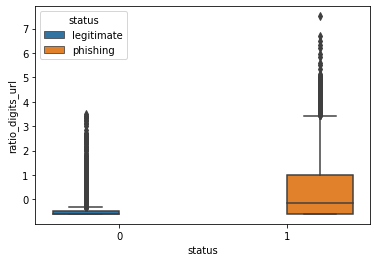

In [16]:
sns.boxplot(x="status", y="ratio_digits_url", data=Full_dataset_standard, hue=status_labels)

### PCA Analysis

2D representation of the data with a PCA:

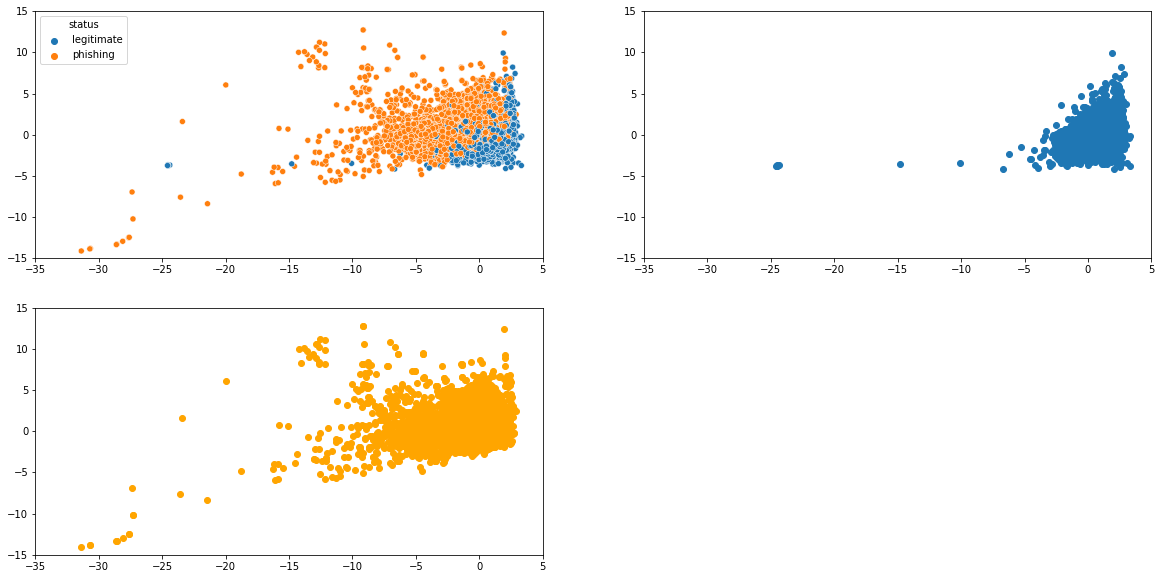

In [17]:
pca2 = perform_pca(Full_dataset_standard, n_comp = 2).values

fig, ax = plt.subplots(2, 2, figsize = (20,10))

sns.scatterplot(x = pca2[:, 0], y = pca2[:, 1], hue = status_labels, ax = ax[0,0]);
ax[0,0].set_xlim(-35, 5)
ax[0,0].set_ylim(-15, 15)

ax[0,1].scatter(x = pca2[Full_dataset_standard["status"] == 0 , 0], y = pca2[Full_dataset_standard["status"] == 0 , 1])
ax[0,1].set_xlim(-35, 5)
ax[0,1].set_ylim(-15, 15)

ax[1,0].scatter(x = pca2[Full_dataset_standard["status"] == 1 , 0], y = pca2[Full_dataset_standard["status"] == 1 , 1], color = "orange")
ax[1,0].set_xlim(-35, 5)
ax[1,0].set_ylim(-15, 15)

ax[1,1].axis('off');

3D visualization with a PCA:

In [18]:
pca3 = perform_pca(Full_dataset_standard, n_comp = 3).values

df = px.data.iris()
fig = px.scatter_3d(x = pca3[:, 0], y = pca3[:, 1], z = pca3[:, 2], color = status_labels)
fig.show()

#### Logistic regression

Loading model and testing

In [27]:
score_torch_model('../models/logiReg.pth', reduced_dataset_standard)

--------------------------------
MODEL ../models/logiReg.pth
Accuracy: 82.694663 %
--------------------------------


Visualizing the best model

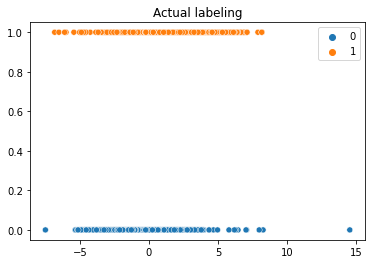

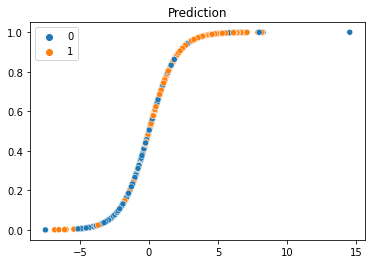

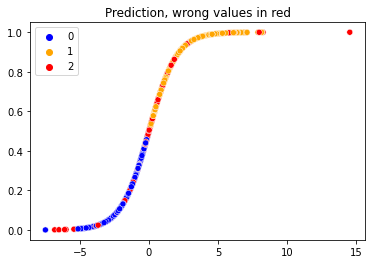

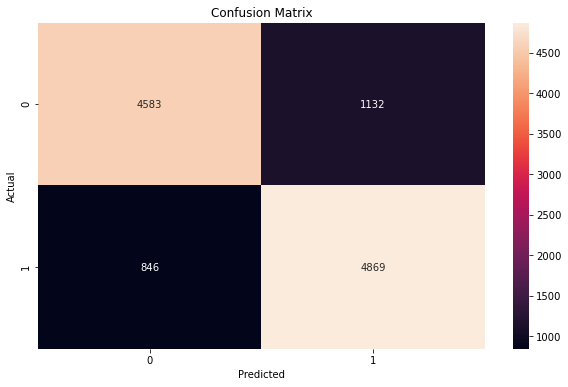

In [28]:
X_torch = torch.tensor(X_standard).float()
Y_torch = torch.tensor(Y)
#Load the saved logistic model
model = pickle.load(open(f'../models/logiReg.pth', 'rb'))

#Parameters from the linear model of the logistic regression
parameters = [param.data for name, param in model.named_parameters()]

#Evaluate each sample in the linear model
linear_model_values = []
preds = []
for sample in X_torch:
    params = parameters[0].numpy()
    bias = parameters[1].numpy()

    p = np.concatenate((bias.reshape(1,1), params.transpose()))        
    x = np.concatenate((np.ones((1, 1)), sample.reshape(sample.shape[0], 1)))

    linear_model_values.append(np.dot(x.T, p)[0][0])
    
    #Get the predictions for each sample
    preds.append(model(sample).detach().numpy()[0])


# Labeling samples by class (predicted and actual)
color_pred = np.array([1 if i >= 0.5 else 0 for i in preds])
color_real = Y.reshape(Y_torch.shape[0])

plt.figure()
plt.title("Actual labeling")
sns.scatterplot(x = linear_model_values, y=Y.T[0], hue=color_real)
plt.show()

plt.figure()
plt.title("Prediction")
sns.scatterplot(x=linear_model_values, y=preds, hue=color_real)
plt.show()

mal1 = [True if (v >= 0.5 and Y.T[0][i] == 0) else False for i,v in enumerate(preds)]
mal2 = [True if (v < 0.5 and Y.T[0][i] == 1) else False for i,v in enumerate(preds)]
mal = np.logical_or(mal1, mal2)

color_pred_mal = color_pred.copy()
color_pred_mal[mal] = 2

plt.figure()
plt.title("Prediction, wrong values in red")
sns.scatterplot(x=linear_model_values, y=preds, hue=color_pred_mal, palette = ["blue", "orange", "red"])
plt.show()

visualize_confusion_matrix(color_pred, color_real)

### SVM

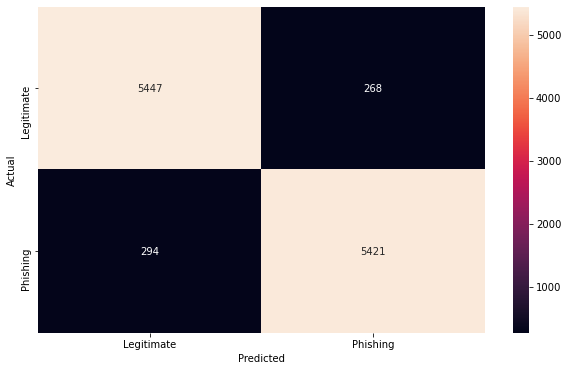

Accuracy score: 0.9508311461067367
Recall score: 0.9485564304461942
F1 score: 0.9507190459487899


In [19]:
_, accuracy, recall, f1_score = predictions_SVM("../../models/LinearFullStd.sav", Full_dataset_standard, confusion_matrix=True)
print("Accuracy score:", accuracy)
print("Recall score:", recall)
print("F1 score:", f1_score)

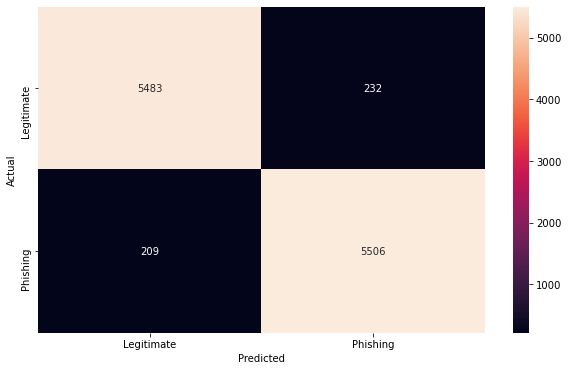

Accuracy score: 0.9614173228346456
Recall score: 0.9634295713035871
F1 score: 0.9614948048546231


In [20]:
_, accuracy, recall, f1_score = predictions_SVM("../../models/RbfReduced15.sav", reduced_dataset_standard15, confusion_matrix=True);
print("Accuracy score:", accuracy)
print("Recall score:", recall)
print("F1 score:", f1_score)

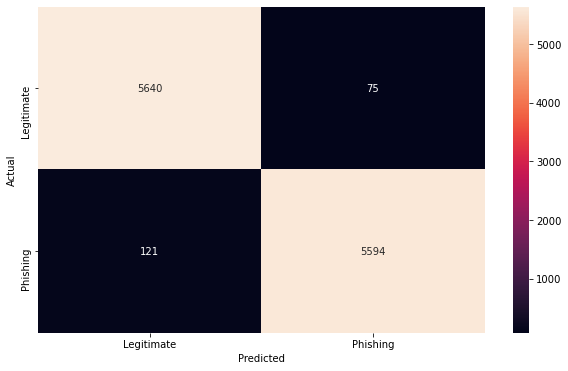

Accuracy score: 0.9828521434820647
Recall score: 0.978827646544182
F1 score: 0.982782853127196


In [21]:
_, accuracy, recall, f1_score = predictions_SVM("../../models/Poly2FullStd.sav", Full_dataset_standard, confusion_matrix=True);
print("Accuracy score:", accuracy)
print("Recall score:", recall)
print("F1 score:", f1_score)

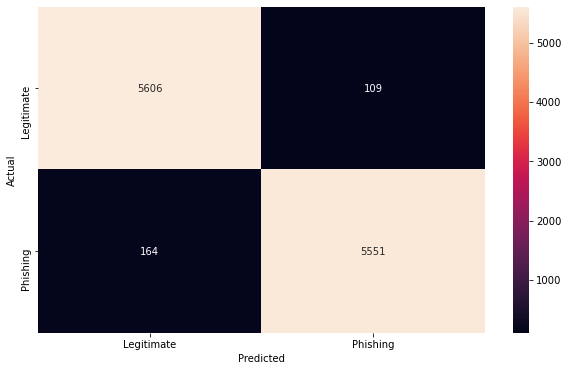

Accuracy score: 0.9761154855643045
Recall score: 0.9713035870516186
F1 score: 0.9760000000000001


In [22]:
_, accuracy, recall, f1_score = predictions_SVM("../../models/Poly2PCA90.sav", pca_dataset90, confusion_matrix=True);
print("Accuracy score:", accuracy)
print("Recall score:", recall)
print("F1 score:", f1_score)

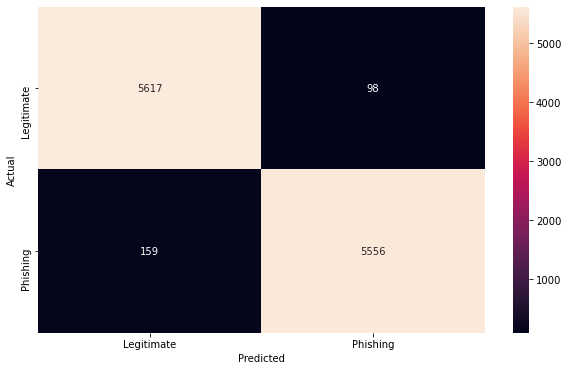

Accuracy score: 0.9775153105861767
Recall score: 0.9721784776902888
F1 score: 0.9773946697158942


In [23]:
_, accuracy, recall, f1_score = predictions_SVM("../../models/Poly2PCA95.sav", pca_dataset95, confusion_matrix=True);
print("Accuracy score:", accuracy)
print("Recall score:", recall)
print("F1 score:", f1_score)

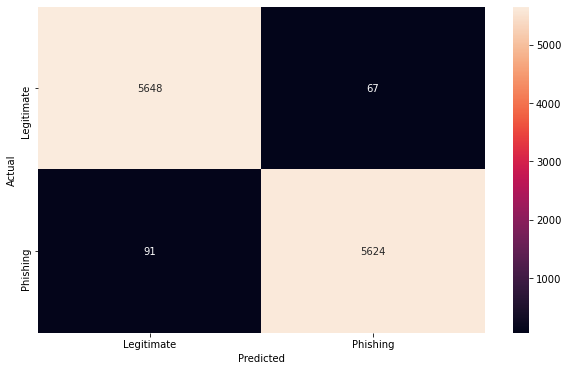

Accuracy score: 0.9861767279090113
Recall score: 0.984076990376203
F1 score: 0.9861476415921445


In [24]:
_, accuracy, recall, f1_score = predictions_SVM("../../models/Poly3Reduced30.sav", reduced_dataset_standard30, confusion_matrix=True);
print("Accuracy score:", accuracy)
print("Recall score:", recall)
print("F1 score:", f1_score)

In [25]:
import numpy as np
import matplotlib.pyplot as plt


def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

In [27]:
def SVM_decision_boundary(dataset, column_pairs, model_params):
    """
    Visual 2D representation the decision boundary of a SVM model.
            Parameters:
                    dataset (pandas dataframe): Dataset used for training
                    column_pairs (list of string lists): A list containing lists with
                        the pairs of features that want to be visualized 
                    model_params (dictionary): Set of hyperparameters (kernel, C, gamma,
                        coef0, degree)
    """
    
    kernel = model_params['kernel']
    C = model_params['C']
    gamma = model_params['gamma']
    coef0 = model_params['coef0']
    degree = model_params['degree']

    
    model = svm.SVC(kernel=kernel, C=C, gamma=gamma, coef0 = coef0, degree=degree)
    
    
    plt.close('all')
    fig, sub = plt.subplots(1, len(column_pairs), figsize=(20,5))
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    
    if (len(column_pairs) == 1):
        aux = [sub]
    else:
        aux = sub.flatten()

    for pair, ax in zip(column_pairs, aux):
        X = dataset[pair].values
        Y = dataset.values[:,-1]
        
        model = model.fit(X, Y)
        
        X0, X1 = X[:, 0], X[:, 1]
        xx, yy = make_meshgrid(X0, X1)
        
        plot_contours(ax, model, xx, yy,
                      cmap=plt.cm.coolwarm, alpha=0.8)
        ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xlabel(pair[0])
        ax.set_ylabel(pair[1])
        ax.set_xticks(())
        ax.set_yticks(())

    plt.show()

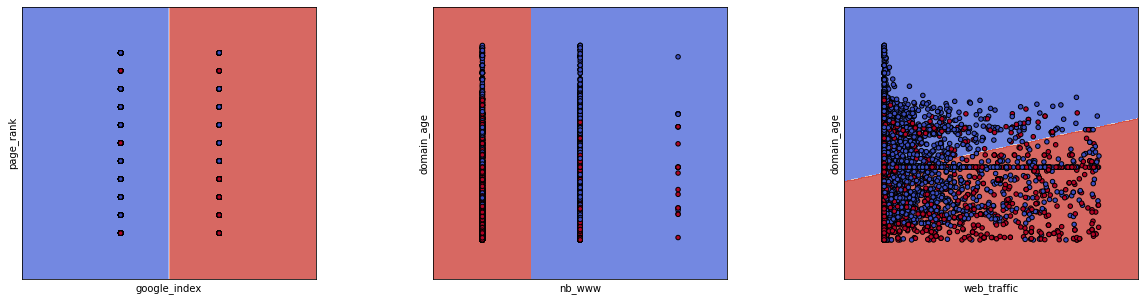

In [29]:
model_params = pickle.load(open("../../models/LinearFullStd.sav", 'rb'))
SVM_decision_boundary(Full_dataset_standard, [['google_index','page_rank'], ["nb_www","domain_age"], ["web_traffic", "domain_age"]], model_params)

In [ ]:
model_params = pickle.load(open("../../models/RbfReduced15.sav", 'rb'))
SVM_decision_boundary(reduced_dataset_standard15, [['google_index','page_rank'], ["nb_www","domain_age"], ["web_traffic", "domain_age"]], model_params)

In [ ]:
model_params = pickle.load(open("../../models/Poly2FullStd.sav", 'rb'))
SVM_decision_boundary(Full_dataset_standard, [['google_index','page_rank'], ["nb_www","domain_age"], ["web_traffic", "domain_age"]], model_params)

In [ ]:
model_params = pickle.load(open("../../models/Poly2PCA90.sav", 'rb'))
SVM_decision_boundary(pca_dataset90, [['pc1','pc2'], ["pc2","pc3"], ["pc1", "pc3"]], model_params)

In [ ]:
model_params = pickle.load(open("../../models/Poly2PCA95.sav", 'rb'))
SVM_decision_boundary(pca_dataset95, [['pc1','pc2'], ["pc2","pc3"], ["pc1", "pc3"]], model_params)

In [ ]:
model_params = pickle.load(open("../../models/Poly3Reduced30.sav", 'rb'))
SVM_decision_boundary(reduced_dataset_standard30, [['google_index','page_rank'], ["nb_www","domain_age"], ["web_traffic", "domain_age"]], model_params)